<a href="https://colab.research.google.com/github/dtsybulskii/EigenValues/blob/main/dz2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div style="float: right">
    **Школа Анализа Данных** — https://yandexdataschool.ru

    <div style="margin-top: 20px">
        <img src="https://yastatic.net/yandex-shad2-www/_/PrcFTNsjcxFOmIVCu7Vzrm4sZFM.svg" width="300px">
    </div>
</div>

# Лабораторная работа 1

Не забываем загрузить библиотеки:

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

In [ ]:
# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy as scipy
import scipy.linalg as sla

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

#### Без точки:

In [ ]:
L = np.array([[1,0], [10 ** 20, 1]])
U = np.array([[10 ** (-20),1], [0, 1 - 10 ** 20]])
np.dot(L, U)

array([[1e-20, 1],
       [1.0, 1]], dtype=object)

#### С точкой:

In [ ]:
L = np.array([[1.,0], [10 ** 20, 1.]])
U = np.array([[10 ** (-20),1.], [0, 1. - 10 ** 20]])
np.dot(L, U)

array([[1e-20, 1.0],
       [1.0, 0.0]], dtype=object)

#### Вывод: во втором случае исчезла единица A [1,1]. Предположение: проблема при изменении типов, в первом случаее элементы в L и U имеют тип int, float соответсвенно и для них вызывается функция перемножения целых чисел и с плавающей точкой, которая возможно хорошо оптимизирована в питоне . Во втором же случае по честному перемножаются float и float по определенному стандарту (для питона это вроде - IEEE 754) и скорее всего ввозникают проблемы с большой арифметикой.

**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$
Это число называется *фактором роста матрицы*.

Но что, если это отношение велико?

**Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, вы можете сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [ ]:
n = 500
A  = np.eye(n) - np.tril(np.ones((n,n)), k = -1)
A[:,n-1] = 1
print('A:\n',A)

A:
 [[ 1.  0.  0. ...  0.  0.  1.]
 [-1.  1.  0. ...  0.  0.  1.]
 [-1. -1.  1. ...  0.  0.  1.]
 ...
 [-1. -1. -1. ...  1.  0.  1.]
 [-1. -1. -1. ... -1.  1.  1.]
 [-1. -1. -1. ... -1. -1.  1.]]


### LU:

In [ ]:
P, L, U = scipy.linalg.lu(A)

In [ ]:
print('P = Id:',np.allclose(P,np.eye(n)))
print('error(2-norm):', np.linalg.norm(A - np.dot(L,U),ord = 2))
print('rho:',np.max(U)/np.max(A))

P = Id: True
error(2-norm): 2.5329519520662918e+76
rho: 1.636695303948071e+150


### QR:

In [ ]:
Q, R = scipy.linalg.qr(A)
print('error(2-norm):', np.linalg.norm(A - np.dot(Q,R),ord = 2))

error(2-norm): 7.72570578611165e-13


К счастью, на практике так редко очень бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1,5 балла)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

Решение:
По определению матрица Паскаля - диагональна. Как известно любая диагональная матрица с ненулевыми минорами имеет разложение $LDL^T$, где $L$ - нижнетреугольная c положительными элементами на диагонали, $D$ - диагональная матрица с $+1,-1$ на диагонали которые определяются знаками миноров матрицы $S_n$. Далее если посмотреть на три первых минора, то можно заметить что все они положительны и более того одинаковы и равны 1, поэтому можно выдвинуть следующую гипотезу о том что все миноры равны 1, тоесть матрица $S_n$ является положительно опредленной из чего можно сделать вывод, что в таком случае $D$ - единичная матрица. В итоге наши рассуждения предагают искать матрицу $S_n$ в виде $LL^T$. Далее для определения структуры матрицы L, можно посмотреть n = 1,2,3 и легко восстановить ее для этих случаев и тем самым получить некую "интуицию" об общем случае, например что диагональ и первый столбец должен состоять из единиц, а внутри должны присутствовать биномиальные коэф. Используя эти рассуждения получаем общий вид матрицы L:
\begin{equation}
l_{ij} = C_{i}^{j}\quad \textrm{при} \: j \leq i
\end{equation}
А искомая $U = L^T$

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

In [ ]:
import math
def my_pascal(n):
    S = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            S[j,i] = S[i,j] = math.factorial(i+j)/math.factorial(i)/math.factorial(j)
    return S
my_pascal(5)

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  3.,  4.,  5.],
       [ 1.,  3.,  6., 10., 15.],
       [ 1.,  4., 10., 20., 35.],
       [ 1.,  5., 15., 35., 70.]])

In [ ]:
A_test = my_pascal(5)

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [ ]:
P, L, U = scipy.linalg.lu(A_test)
scipy.linalg.norm(A_test-np.dot(np.dot(P,L),U),ord  = 2)

0.0

Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [ ]:
A = my_pascal(30)
print('determinant: ', sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x).reshape(30, 1) # для linalg.solve из scipy
x1 = sla.solve(A, b)
print('residual: ', sla.norm(x1 - x))

determinant:  2.4794776250900227e+49
residual:  170849299.4107653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: LinAlgWarning: Ill-conditioned matrix (rcond=2.10719e-25): result may not be accurate.
  import sys


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [ ]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print('residual: ', sla.norm(x2 - x))


residual:  1036027366.0210774


Объясните полученные неприятные результаты.

#### Вычислительная ошибка накопилась из-за большого числа обусловленности, как у матрицы A так и у R.


In [ ]:
print('cond A =', np.linalg.cond(A))
print('cond R =', np.linalg.cond(R))

cond A = 3.940994367801505e+24
cond R = 3.317260184105894e+24


## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [ ]:
def naive_solve(A, b):
    return np.dot(np.linalg.inv(A),b)

def standard_solve(A, b):
    return sla.solve(A, b)

def cholesky_solve(A, b):
    R = sla.cholesky(A)
    y = sla.solve_triangular(R.T,b,lower=True)
    return sla.solve_triangular(R,y)

def cho_scipy_solve(A, b):
    c, low = sla.cho_factor(A)
    return sla.cho_solve((c,low),b)

Генерировать матрицу $A$ будем в виде: $CC^T$, где $C$ - произвольная невырожденная случайная матрица . Тогда $A = A^T \geq 0$. Вообще говоря, если мы будем генерировать матрицу из случайных величин с абсолютно непрерывным распределением, то вероятность того, что матрица получится вырожденной равна нулю, но в теории на практике из-за округлений
мы все же можем получить вырожденную матрицу. Но из-за высокой точности будем считать что это практически невозможно и не будем делать дополнительные проверки на определитель при генерации матрицы $C$

In [ ]:
def gen(n):
    C = np.random.randn(n,n)
    return np.dot(C,C.T)

Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [ ]:
n = 4
A = gen(n)
x = np.ones(n)
b = np.dot(A,x)
print('naive:',np.allclose(x, naive_solve(A, b)))
print('standard:',np.allclose(x, standard_solve(A, b)))
print('cholesky:',np.allclose(x, cholesky_solve(A, b)))
print('cho scipy:',np.allclose(x, cho_scipy_solve(A, b)))


naive: True
standard: True
cholesky: True
cho scipy: True


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные, например, с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

#### 1) Зависимость от размерности $ A $(на всякий случай: в гугл колабе надо подождать +- 40 с)


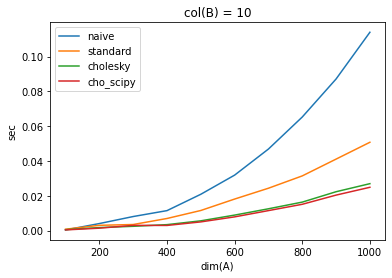

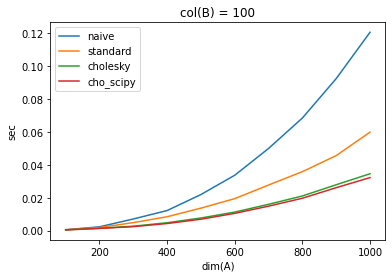

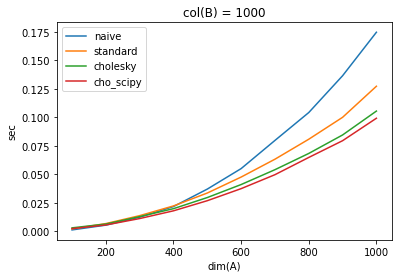

In [ ]:
for j in range(1,4,1):
    Y_naive = []
    Y_standard = []
    Y_cholesky = []
    Y_cho_scipy = []
    for i in range(100,1100,100):
        B = np.random.randn(i,10 ** j)
        A = gen(i)
        Y_naive.append(min(timeit.repeat('naive_solve(A,B)', "from __main__ import A,B,naive_solve",number= 1,repeat= 10)))
        Y_standard.append(min(timeit.repeat('standard_solve(A,B)', "from __main__ import A,B,standard_solve",number= 1,repeat= 10)))
        Y_cholesky.append(min(timeit.repeat('cholesky_solve(A,B)', "from __main__ import A,B,cholesky_solve",number= 1,repeat= 10)))
        Y_cho_scipy.append(min(timeit.repeat('cho_scipy_solve(A,B)', "from __main__ import A,B,cho_scipy_solve",number= 1,repeat= 10)))
        #%timeit naive_solve(A,B)
        #%timeit standard_solve(A,B)
        #%timeit cholesky_solve(A,B)
        #%timeit cho_scipy_solve(A,B)
    X = np.arange(100,1100,100)
    Y_naive = np.array(Y_naive)
    Y_standard = np.array(Y_standard)
    Y_cholesky = np.array(Y_cholesky)
    Y_cho_scipy = np.array(Y_cho_scipy)
    plt.figure(j)
    plt.plot(X,np.array(Y_naive),label = 'naive')
    plt.plot(X,np.array(Y_standard),label = 'standard')
    plt.plot(X,np.array(Y_cholesky),label = 'cholesky')
    plt.plot(X,np.array(Y_cho_scipy),label = 'cho_scipy')

    plt.title('col(B) = ' + str(10 ** j))
    plt.xlabel('dim(A)')
    plt.ylabel('sec')
    plt.legend()


#### 2) Зависимость от количества столбцов $B$ при фиксированном $A$(dim(A) = 500)

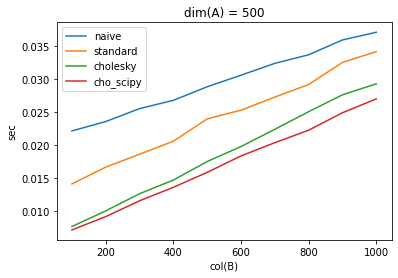

In [ ]:
Y_naive = []
Y_standard = []
Y_cholesky = []
Y_cho_scipy = []
i = 500
for j in range(100,1100,100):
    B = np.random.randn(i,j)
    A = gen(i)
    Y_naive.append(min(timeit.repeat('naive_solve(A,B)', "from __main__ import A,B,naive_solve",number= 1,repeat= 10)))
    Y_standard.append(min(timeit.repeat('standard_solve(A,B)', "from __main__ import A,B,standard_solve",number= 1,repeat= 10)))
    Y_cholesky.append(min(timeit.repeat('cholesky_solve(A,B)', "from __main__ import A,B,cholesky_solve",number= 1,repeat= 10)))
    Y_cho_scipy.append(min(timeit.repeat('cho_scipy_solve(A,B)', "from __main__ import A,B,cho_scipy_solve",number= 1,repeat= 10)))
    #%timeit naive_solve(A,B)
    #%timeit standard_solve(A,B)
    #%timeit cholesky_solve(A,B)
    #%timeit cho_scipy_solve(A,B)
X = np.arange(100,1100,100)

plt.plot(X,np.array(Y_naive),label = 'naive')
plt.plot(X,np.array(Y_standard),label = 'standard')
plt.plot(X,np.array(Y_cholesky),label = 'cholesky')
plt.plot(X,np.array(Y_cho_scipy),label = 'cho_scipy')

plt.title('dim(A) = ' + str(i))
plt.xlabel('col(B)')
plt.ylabel('sec')
plt.legend()

#### Вывод: лучший вариант - использовать библиотечную функцию для разложения холекцого или писать самому через разложение холецкого.

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3,5 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

In [ ]:
from scipy.stats import multivariate_normal

#Заготовка:
def my_multivariate_normal_logpdf(X, m, S):
    D = m.shape[0]
    R = sla.cholesky(S)
    out = -D/2 * np.log(2 * np.pi) - np.log(R.diagonal().prod())
    Z = np.dot(np.linalg.inv(R.T),(X - m).T)
    out -= 1/2 * np.dot(Z.T,Z).diagonal()
    return out

#### Проверка на совпадение ответов:

In [ ]:
D = 6
N = 5
X_testing = np.random.multivariate_normal(np.random.randn(D), np.eye(D), N)
S = gen(D)
m = np.random.randn(D)
np.allclose( my_multivariate_normal_logpdf(X_testing, m, S), scipy.stats.multivariate_normal.logpdf(X_testing, mean=m, cov=S))

True

Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [ ]:
N = 100
for D in range(100,400,100):
    X_testing = np.random.multivariate_normal(np.random.randn(D), np.eye(D), N)
    S = gen(D)
    m = np.random.randn(D)

    print('\nN = ' + str(N),'D = ' + str(D))
    print('my:')
    %timeit my_multivariate_normal_logpdf(X_testing, m, S)
    print('scipy:')
    %timeit scipy.stats.multivariate_normal.logpdf(X_testing, mean=m, cov=S)


N = 100 D = 100
my:
1000 loops, best of 5: 1.31 ms per loop
scipy:
100 loops, best of 5: 3.37 ms per loop

N = 100 D = 200
my:
100 loops, best of 5: 4.7 ms per loop
scipy:
100 loops, best of 5: 14.4 ms per loop

N = 100 D = 300
my:
100 loops, best of 5: 13.9 ms per loop
scipy:
10 loops, best of 5: 28.7 ms per loop


### Получилось обогнать библиотечную функцию, использовали лишь разложение холецкого для подсчета определителя и произведения в экспоненте

YOUR ANSWER HERE

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

## Часть 3. Матричные дифференцирования

В данном блоке вам нужно $\textbf{обязательно}$ написать полное решение, используя `Markdown` разметку, а не только ответ. В противном случае за задание будет ставиться 0 баллов.

**Задача 3.1 (1 балл)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

По определению:
$\frac{\partial g}{\partial X} = \left(\frac{\partial g}{\partial x_{ij}}\right)$.
Выразим производные функции $g$ через производные функции $f$:

1)

 $ i = j$, $тогда \frac{\partial g}{\partial x_{ii}} = \lim_{h\to\infty} \frac{g(...,x_{ii}+h,...) - g(...,x_{ii},...)}{h} = \lim_{h\to\infty} \frac{f(...,x_{ii}+h,...) - f(...,x_{ii},...)}{h} = \frac{\partial f}{\partial x_{ii}}$

 2)
 
 $\ i \neq j, \frac{\partial g}{\partial x_{ij}} = \lim_{h\to\infty} \frac{g(...,x_{ij}+h,...,x_{ji}+h,...) - g(...,x_{ij},...,x_{ji},...)}{h} = \lim_{h\to\infty} \frac{f(...,x_{ij}+h,...,x_{ji}+h,...) - f(...,x_{ij},...,x_{ji},...) }{h} = \nabla f \cdot (0,...,0,1,0,...,0,1,0,...,0)^T = \frac{\partial f}{\partial x_{ij}} + \frac{\partial f}{\partial x_{ji}}$

 Используя эти покомпонентные выражения требуемый матричный вид становится очевидным



**Задача 3.2 (1 балл)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

$$\frac{\partial tr\left(AX^2BX^{-T}\right)}{\partial x_{ij}} = tr \frac{\partial\left(AX^2BX^{-T}\right)}{\partial x_{ij}} = tr(AE_{ij}XBX^{-T})+tr(AXE_{ij}BX^{-T}) + tr(-AX^2BX^{-T}E_{ji}X^{-T}) = tr(XBX^{-T}AE_{ij})+tr(BX^{-T}AXE_{ij}) + tr(-X^{-T}AX^2BX^{-T}E_{ji}) = (XBX^{-T}A)_{ji} + (BX^{-T}AX)_{ji} + (-X^{-T}AX^2BX^{-T})_{ij}$$
$$\downarrow$$
$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X} = (XBX^{-T}A)^T + (BX^{-T}AX)^T + (-X^{-T}AX^2BX^{-T}) $$

**Задача 3.3 (1 балл)** Найдите производную
$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial x_{ij}} = tr\left(\left(\frac{\partial \ln \det Y}{\partial 
Y}\bigg|_{Y = X^TAX}\right)^T \frac{\partial X^TAX}{\partial x_{ij}}\right) = tr\left((X^TAX)^{-1}(E_{ji}AX+X^TAE_{ij})\right) = \left(AX(X^TAX)^{-1}\right)_{ij}+ \left((X^TAX)^{-1}X^TA\right)_{ji} $$
$$\downarrow$$
$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X} = AX(X^TAX)^{-1}+ \left((X^TAX)^{-1}X^TA\right)^T$$YOUR ANSWER HERE

**Задача 3.4 (2 балла)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.

$$l(Y|\Sigma,{\bf m}) = C - \frac{1}{2}m\ln\det\Sigma - \sum_i\frac{1}{2}(y_i-{\bf m})^T\Sigma^{-1}(y_i-{\bf m })$$

1) Опм для математического ожидания.

 Зафиксируем $\Sigma$, и найдем оптимальный $\bf m$  для нее:
$$\frac{\partial l(Y|\Sigma,{\bf m})}{\partial{\bf m }} = \sum_i\Sigma^{-1}(y_i-{\bf m }) = 0$$
Воспользовались симметричностью $\Sigma$. Отсюда используя невырожденность матрицы ковариации получаем:
$$ {\hat{\bf m}} =\overline{Y}$$
Получили, что ${\hat{\bf m}}$ не зависит от матрицы ковариации, это значит, что глобальный оптимум достигается на таком значеним ${\hat{\bf m}}$, значит найденная оценка для математического ожидания действительно является омп



2)Омп для матрицы ковариации.
Будем решать задачу минимизации с условием : $\Sigma = \Sigma^T$.Для этого будем использовать метод Лагранжа.Пусть так же $L = (\lambda_{ij})$ - лагранжевы переменые
. Так же воспользуемся очевидным равенством:
$$(y_i-{{\hat{\bf m}}})^T\Sigma^{-1}(y_i-{{\hat{\bf m}}})  = tr\left((y_i-{\bf m})^T\Sigma^{-1}(y_i-{{\hat{\bf m}} })\right) = tr\left((y_i-{{\hat{\bf m}}})(y_i-{{\hat{\bf m}} })^T\Sigma^{-1}\right)$$Тогда искомая система примет вид:
$$\frac{\partial}{\partial \Sigma}\left( C - \frac{1}{2}m\ln\det\Sigma - \frac{1}{2}\sum_itr\left((y_i-{{\hat{\bf m}}})(y_i-{{\hat{\bf m}} })^T\Sigma^{-1}\right) - tr(L^T(\Sigma-\Sigma^T) \right) = 0$$
Получим:
$$-\frac{1}{2}m\Sigma^{-T} + \frac{1}{2} \left(\Sigma^{-1} \sum_i (y_i-{{{\hat{\bf m}}}})(y_i-{{\hat{\bf m}} })^T \Sigma^{-1}\right)^T + L - L^T = 0 $$
Пользуясь симемтричностью матрицы $\Sigma$, сложив с транспонированным равенством получим:
$$\hat \Sigma  = \frac{1}{m}\sum_i (y_i-{{\hat{\bf m}}})(y_i-{{\hat{\bf m}} })^T$$
Стоит заметить, что решение мы искали лишь в классе симметрических
матриц, чего явно было не достаточно для того чтобы утверждать, что полученная оценка на матрицу ковариации будет корректной т.к нужно еще необходимое требование
на положительную определенность, к счастью нам очень повезло и полученная оценка на матрицу получилась действительно положительно определенной.

## Часть 4. Линейная Алгебра и Машинное Обучение  

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \frac1{N}\sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 10^{-4}}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [ ]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)

**Задача 4.0 (1 балл)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [ ]:
def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float 
    '''
    return np.logaddexp(-y * np.dot(X,w),0).mean() + 10 ** -4 / 2 * np.linalg.norm(w, ord = 2) ** 2 


In [ ]:
print(logistic(w, X, y))

1.6782084705285742


**Задача 4.1 (1.5 балла)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций. Подробное решение (как в блоке с матричными производными) нужно обязательно записать ниже!

Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

$$ \frac{\partial L}{\partial w_j} = \frac{-1}{N}\sum_{i = 0}^{N} {y_ix_{ij}} \left(1 - \frac{1}{1 + exp(-y_ix_i^Tw)}\right) + C w_j$$

In [ ]:
def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    # YOUR CODE HERE
    return -((X * y[np.newaxis].T) * ((np.exp(-y * np.dot(X,w)) * scipy.special.expit(y * np.dot(X,w))))[np.newaxis].T).mean(axis = 0) + 10 ** -4 * w

In [ ]:
assert(logistic_grad(w, X, y).shape == w.shape)

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать.

In [ ]:

def max_error(a, b):
    return np.max(np.abs(a-b))

def grad_finite_diff(func, x, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента

        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    x, fval, dnum = x.astype(np.float64), func(x), np.zeros_like(x)

    # YOUR CODE HER
    E =np.eye(x.size) * eps
    g = lambda w: logistic(w, X, y)
    dnum = (np.apply_along_axis(g,-1,x + E) - np.apply_along_axis(g,-1,x)) / eps
    return dnum

In [ ]:
mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')



err =  3.512015395168433e-08 ok


**Задача 4.2 (2.5 балла)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?
    
Эффективно запрограммируйте вычисление гессиана.

---
*Вычислите гессиан здесь*

In [ ]:
def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    
    #hessw = # Гессиан dL/dw_iw_j
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана.

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-4}$

In [ ]:
def hess_finite_diff(func, w, eps=1e-4):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    #dnum = # Вычислите численный гессиан d func/dw_iw_j для всех i, j
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-4 else 'ошибка оч большая =(')
